In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import scipy.spatial as sd
from itertools import cycle
import networkx as nx

In [3]:
def calcSqDistances(X, Kmus):
    sqDmat = np.zeros((X.shape[0], Kmus.shape[0]))
    
    for i in range(Kmus.shape[0]):
        sqDmat[:, i] = np.sum((np.abs(X-Kmus[i,  :]))**2, 1)
    
    return sqDmat

def determineRnk(sqDmat):
    Rnk = np.zeros(sqDmat.shape)
    Rnk[np.arange(Rnk.shape[0]), np.argmin(sqDmat, 1)] = 1
    return Rnk

def recalcMus(X, Rnk):
    Kmus = np.zeros((Rnk.shape[1], X.shape[1]))
        
    for i in range(Rnk.shape[1]):
        Kmus[i, :] = np.sum(X[(Rnk[:, i] == 1), :]/np.sum(Rnk[:, i]), 0)
    
    return Kmus

def runKMeans(train_data, K, seed=256):
    N = train_data.shape[0]
    D = train_data.shape[1]
    
    Kmus = np.zeros((K, D))

    rng_gen = np.random.default_rng(seed=seed)
    rand_idxs = rng_gen.choice(N, K, replace=False)

    Kmus = train_data[rand_idxs, :]
    
    maxiter = 1000
    
    for i in tqdm(range(maxiter)):
        sqDmat = calcSqDistances(train_data, Kmus)
        Rnk = determineRnk(sqDmat)
        
        KmusOld = Kmus
        Kmus = recalcMus(train_data, Rnk)
        
        if np.sum(np.abs(KmusOld-Kmus)) < 1e-6:
            print('Finished in {} iterations'.format(i))
            break
        
        cur_it = i

    cluster_groups = np.argmin(sqDmat, 1)
    return Kmus, cluster_groups, cur_it


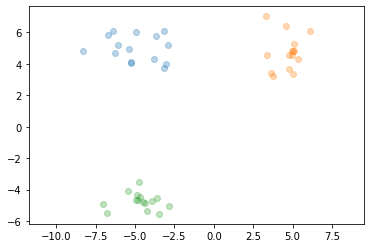

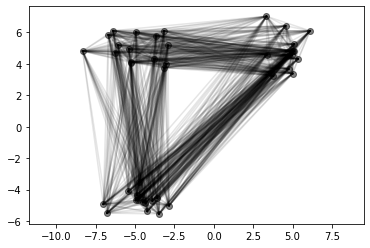

In [8]:
mu1, cov1 = np.array([-5, 5]), np.array([[2, 0], [0, 1]])
mu2, cov2 = np.array([5, 5]), np.array([[1, 0], [0, 1]])
mu3, cov3 = np.array([-5, -5]), np.array([[1, 0], [0, 1]])

n = 15

x1, y1 = np.random.multivariate_normal(mu1, cov1, n).T
x2, y2 = np.random.multivariate_normal(mu2, cov2, n).T
x3, y3 = np.random.multivariate_normal(mu3, cov3, n).T
plt.plot(x1, y1, 'o', alpha = 0.3)
plt.plot(x2, y2, 'o', alpha = 0.3)
plt.plot(x3, y3, 'o', alpha = 0.3)
plt.axis('equal')
plt.show()

xdata = np.concatenate((x1, x2, x3))
ydata = np.concatenate((y1, y2, y3))

data = np.concatenate((xdata[:, np.newaxis], ydata[:, np.newaxis]), axis=1)

adj = sd.distance.cdist(data, data)
edge_list = []
for i in range(data.shape[0]):
    for j in range(i+1, data.shape[0]):
        b = (i, j, adj[i, j])
        edge_list.append(b)

plt.figure()
for node in edge_list:
    x1, y1 = data[node[0], 0], data[node[0], 1]
    x2, y2 = data[node[1], 0], data[node[1], 1]
    plt.plot([x1, x2], [y1, y2],'-', color='black', alpha=0.1)
plt.plot(data[:, 0], data[:, 1], 'o', color='black', alpha=0.5)
plt.axis('equal')
plt.show()


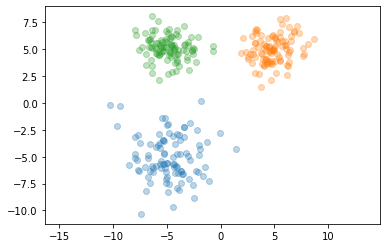

  0%|          | 3/1000 [00:00<00:00, 1047.01it/s]


Finished in 3 iterations


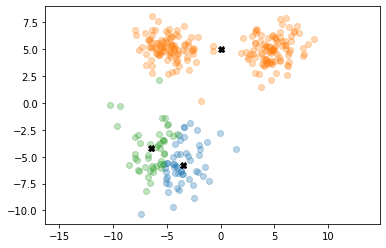

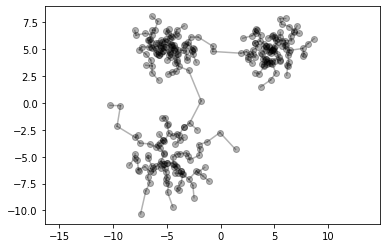

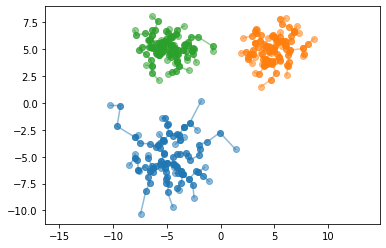

In [34]:
mu1, cov1 = np.array([-5, 5]), np.array([[2, 0], [0, 1]])
mu2, cov2 = np.array([5, 5]), np.array([[2, 0], [0, 2]])
mu3, cov3 = np.array([-5, -5]), np.array([[5, 0], [0, 5]])

n = 100

x1, y1 = np.random.multivariate_normal(mu1, cov1, n).T
x2, y2 = np.random.multivariate_normal(mu2, cov2, n).T
x3, y3 = np.random.multivariate_normal(mu3, cov3, n).T

colors = ['tab:green','tab:orange','tab:blue']
colors = cycle(colors)

plt.plot(x1, y1, 'o', color=next(colors), alpha = 0.3)
plt.plot(x2, y2, 'o', color=next(colors), alpha = 0.3)
plt.plot(x3, y3, 'o', color=next(colors), alpha = 0.3)
plt.axis('equal')
plt.show()

xdata = np.concatenate((x1, x2, x3))
ydata = np.concatenate((y1, y2, y3))

data = np.concatenate((xdata[:, np.newaxis], ydata[:, np.newaxis]), axis=1)

#----------------------------------------------------------------

K = 3
mus, cg, _ = runKMeans(data, K)

clusters = []

for i in range(K):
    idx = cg == i
    clusters.append(data[idx, :])
    plt.plot(data[idx, 0], data[idx, 1], 'o', alpha = 0.3)
    plt.plot(mus[i, 0], mus[i, 1], 'X', color='black')
plt.axis('equal')
plt.show()

#----------------------------------------------------------------

adj = sd.distance.cdist(data, data)
edge_list = []
for i in range(data.shape[0]):
    for j in range(i+1, data.shape[0]):
        b = (i, j, adj[i, j])
        edge_list.append(b)


G = nx.Graph()
G.add_weighted_edges_from(edge_list)

T = nx.minimum_spanning_tree(G)

for node in T.edges():
    x1, y1 = data[node[0], 0], data[node[0], 1]
    x2, y2 = data[node[1], 0], data[node[1], 1]
    plt.plot([x1, x2], [y1, y2],'-', color='black', alpha=0.3)
plt.plot(data[:, 0], data[:, 1], 'o', color='black', alpha=0.3)
plt.axis('equal')
plt.show()



B = list(T.edges(data=True))
B = sorted(B, key = lambda x: (x[2])['weight'])
B = B[-(K-1):]
T.remove_edges_from(B)
components = [T.subgraph(c).copy() for c in nx.connected_components(T)]


for i, subtree in enumerate(components):
  tree_edges = subtree.edges()
  clr = next(colors)
  for node in tree_edges:
      x1, y1 = data[node[0], 0], data[node[0], 1]
      x2, y2 = data[node[1], 0], data[node[1], 1]
      plt.plot([x1, x2], [y1, y2],'-o', color=clr, alpha=0.5)
plt.axis('equal')
plt.show()


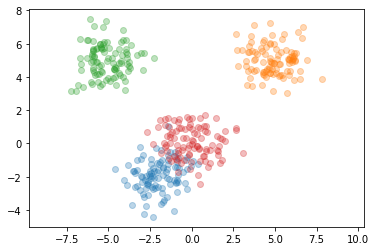

  1%|          | 6/1000 [00:00<00:00, 1423.08it/s]

Finished in 6 iterations


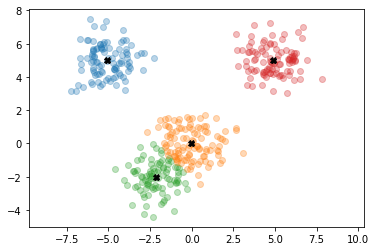

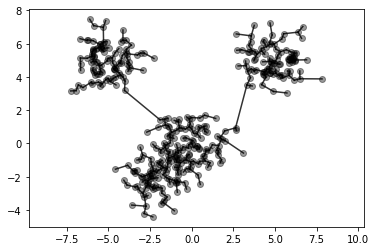

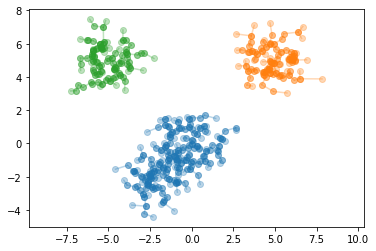

In [26]:
mu1, cov1 = np.array([-5, 5]), np.array([[1, 0], [0, 1]])
mu2, cov2 = np.array([5, 5]), np.array([[1, 0], [0, 1]])
mu3, cov3 = np.array([-2, -2]), np.array([[1, 0], [0, 1]])
mu4, cov4 = np.array([0, 0]), np.array([[1, 0], [0, 1]])

n = 100

x1, y1 = np.random.multivariate_normal(mu1, cov1, n).T
x2, y2 = np.random.multivariate_normal(mu2, cov2, n).T
x3, y3 = np.random.multivariate_normal(mu3, cov3, n).T
x4, y4 = np.random.multivariate_normal(mu4, cov4, n).T

colors = ['tab:green','tab:orange','tab:blue', 'tab:red']
colors = cycle(colors)

plt.plot(x1, y1, 'o', color=next(colors), alpha = 0.3)
plt.plot(x2, y2, 'o', color=next(colors), alpha = 0.3)
plt.plot(x3, y3, 'o', color=next(colors), alpha = 0.3)
plt.plot(x4, y4, 'o', color=next(colors), alpha = 0.3)

plt.axis('equal')
plt.show()

xdata = np.concatenate((x1, x2, x3, x4))
ydata = np.concatenate((y1, y2, y3, y4))

data = np.concatenate((xdata[:, np.newaxis], ydata[:, np.newaxis]), axis=1)

#----------------------------------------------------------------

K = 4
mus, cg, _ = runKMeans(data, K)

clusters = []

for i in range(K):
    idx = cg == i
    clusters.append(data[idx, :])
    plt.plot(data[idx, 0], data[idx, 1], 'o', color=next(colors), alpha = 0.3)
    plt.plot(mus[i, 0], mus[i, 1], 'X', color='black')
plt.axis('equal')
plt.show()

#----------------------------------------------------------------

adj = sd.distance.cdist(data, data)
edge_list = []
for i in range(data.shape[0]):
    for j in range(i+1, data.shape[0]):
        b = (i, j, adj[i, j])
        edge_list.append(b)

G = nx.Graph()
G.add_weighted_edges_from(edge_list)

T = nx.minimum_spanning_tree(G)

for node in T.edges():
    x1, y1 = data[node[0], 0], data[node[0], 1]
    x2, y2 = data[node[1], 0], data[node[1], 1]
    plt.plot([x1, x2], [y1, y2],'-', color='black', alpha=0.8)
plt.plot(data[:, 0], data[:, 1], 'o', color='black', alpha=0.4)
plt.axis('equal')
plt.show()


B = list(T.edges(data=True))
B = sorted(B, key = lambda x: (x[2])['weight'])
B = B[-(K-1):]
T.remove_edges_from(B)
components = [T.subgraph(c).copy() for c in nx.connected_components(T)]




for i, subtree in enumerate(components):
  tree_edges = subtree.edges()
  clr = next(colors)
  for node in tree_edges:
      x1, y1 = data[node[0], 0], data[node[0], 1]
      x2, y2 = data[node[1], 0], data[node[1], 1]
      plt.plot([x1, x2], [y1, y2],'-o', color=clr, alpha=0.3)
plt.axis('equal')
plt.show()


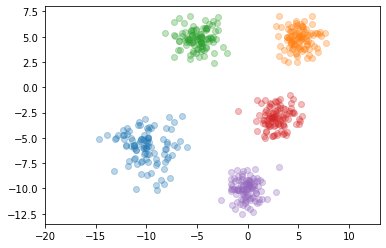

  1%|          | 6/1000 [00:00<00:02, 466.97it/s]


Finished in 6 iterations


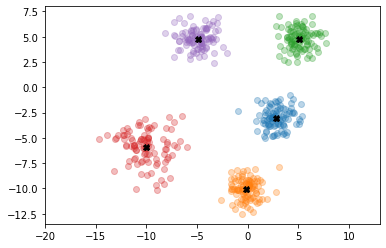

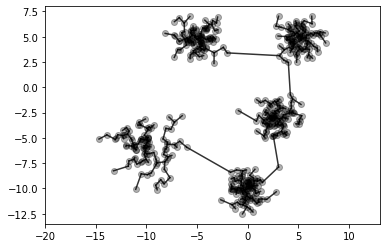

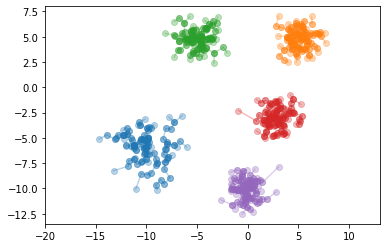

In [29]:
mu1, cov1 = np.array([-5, 5]), np.array([[1, 0], [0, 1]])
mu2, cov2 = np.array([5, 5]), np.array([[1, 0], [0, 1]])
mu3, cov3 = np.array([-10, -6]), np.array([[3, 0], [0, 3]])
mu4, cov4 = np.array([3, -3]), np.array([[1, 0], [0, 1]])
mu5, cov5 = np.array([0, -10]), np.array([[1, 0], [0, 1]])

n = 100

x1, y1 = np.random.multivariate_normal(mu1, cov1, n).T
x2, y2 = np.random.multivariate_normal(mu2, cov2, n).T
x3, y3 = np.random.multivariate_normal(mu3, cov3, n).T
x4, y4 = np.random.multivariate_normal(mu4, cov4, n).T
x5, y5 = np.random.multivariate_normal(mu5, cov5, n).T

colors = ['tab:green','tab:orange','tab:blue', 'tab:red', 'tab:purple']
colors = cycle(colors)

plt.plot(x1, y1, 'o', color=next(colors), alpha = 0.3)
plt.plot(x2, y2, 'o', color=next(colors), alpha = 0.3)
plt.plot(x3, y3, 'o', color=next(colors), alpha = 0.3)
plt.plot(x4, y4, 'o', color=next(colors), alpha = 0.3)
plt.plot(x5, y5, 'o', color=next(colors), alpha = 0.3)

plt.axis('equal')
plt.show()

xdata = np.concatenate((x1, x2, x3, x4, x5))
ydata = np.concatenate((y1, y2, y3, y4, y5))

data = np.concatenate((xdata[:, np.newaxis], ydata[:, np.newaxis]), axis=1)

#----------------------------------------------------------------

K = 5
mus, cg, _ = runKMeans(data, K)

clusters = []

for i in range(K):
    idx = cg == i
    clusters.append(data[idx, :])
    plt.plot(data[idx, 0], data[idx, 1], 'o', color=next(colors), alpha = 0.3)
    plt.plot(mus[i, 0], mus[i, 1], 'X', color='black')
plt.axis('equal')
plt.show()

#----------------------------------------------------------------

adj = sd.distance.cdist(data, data)
edge_list = []
for i in range(data.shape[0]):
    for j in range(i+1, data.shape[0]):
        b = (i, j, adj[i, j])
        edge_list.append(b)

G = nx.Graph()
G.add_weighted_edges_from(edge_list)

T = nx.minimum_spanning_tree(G)

for node in T.edges():
    x1, y1 = data[node[0], 0], data[node[0], 1]
    x2, y2 = data[node[1], 0], data[node[1], 1]
    plt.plot([x1, x2], [y1, y2],'-', color='black', alpha=0.8)
plt.plot(data[:, 0], data[:, 1], 'o', color='black', alpha=0.3)
plt.axis('equal')
plt.show()



B = list(T.edges(data=True))
B = sorted(B, key = lambda x: (x[2])['weight'])
B = B[-(K-1):]
T.remove_edges_from(B)
components = [T.subgraph(c).copy() for c in nx.connected_components(T)]




for i, subtree in enumerate(components):
  tree_edges = subtree.edges()
  clr = next(colors)
  for node in tree_edges:
      x1, y1 = data[node[0], 0], data[node[0], 1]
      x2, y2 = data[node[1], 0], data[node[1], 1]
      plt.plot([x1, x2], [y1, y2],'-o', color=clr, alpha=0.3)
plt.axis('equal')
plt.show()

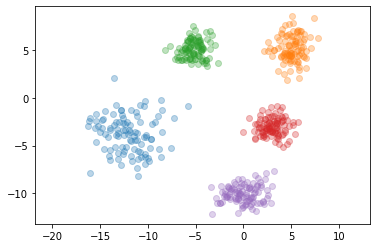

  0%|          | 3/1000 [00:00<00:01, 901.94it/s]

Finished in 3 iterations


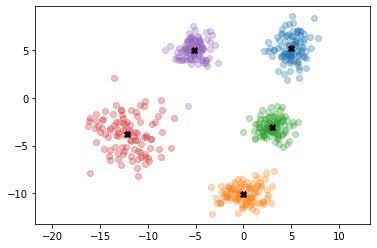

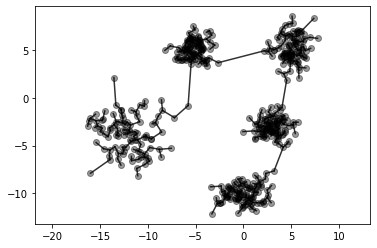

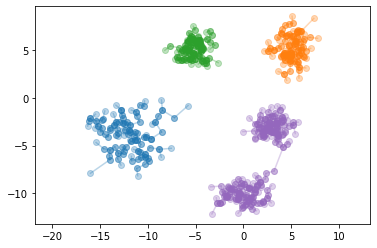

In [31]:
mu1, cov1 = np.array([-5, 5]), np.array([[1, 0], [0, 1]])
mu2, cov2 = np.array([5, 5]), np.array([[1, 0], [0, 2]])
mu3, cov3 = np.array([-12, -4]), np.array([[4, 0], [0, 4]])
mu4, cov4 = np.array([3, -3]), np.array([[1, 0], [0, 1]])
mu5, cov5 = np.array([0, -10]), np.array([[2, 0], [0, 1]])

n = 100

x1, y1 = np.random.multivariate_normal(mu1, cov1, n).T
x2, y2 = np.random.multivariate_normal(mu2, cov2, n).T
x3, y3 = np.random.multivariate_normal(mu3, cov3, n).T
x4, y4 = np.random.multivariate_normal(mu4, cov4, n).T
x5, y5 = np.random.multivariate_normal(mu5, cov5, n).T

colors = ['tab:green','tab:orange','tab:blue', 'tab:red', 'tab:purple']
colors = cycle(colors)

plt.plot(x1, y1, 'o', color=next(colors), alpha = 0.3)
plt.plot(x2, y2, 'o', color=next(colors), alpha = 0.3)
plt.plot(x3, y3, 'o', color=next(colors), alpha = 0.3)
plt.plot(x4, y4, 'o', color=next(colors), alpha = 0.3)
plt.plot(x5, y5, 'o', color=next(colors), alpha = 0.3)

plt.axis('equal')
plt.show()

xdata = np.concatenate((x1, x2, x3, x4, x5))
ydata = np.concatenate((y1, y2, y3, y4, y5))

data = np.concatenate((xdata[:, np.newaxis], ydata[:, np.newaxis]), axis=1)

#----------------------------------------------------------------

K = 5
mus, cg, _ = runKMeans(data, K)

clusters = []

for i in range(K):
    idx = cg == i
    clusters.append(data[idx, :])
    plt.plot(data[idx, 0], data[idx, 1], 'o', color=next(colors), alpha = 0.3)
    plt.plot(mus[i, 0], mus[i, 1], 'X', color='black')
plt.axis('equal')
plt.show()

#----------------------------------------------------------------

adj = sd.distance.cdist(data, data)
edge_list = []
for i in range(data.shape[0]):
    for j in range(i+1, data.shape[0]):
        b = (i, j, adj[i, j])
        edge_list.append(b)

G = nx.Graph()
G.add_weighted_edges_from(edge_list)

T = nx.minimum_spanning_tree(G)

for node in T.edges():
    x1, y1 = data[node[0], 0], data[node[0], 1]
    x2, y2 = data[node[1], 0], data[node[1], 1]
    plt.plot([x1, x2], [y1, y2],'-', color='black', alpha=0.8)
plt.plot(data[:, 0], data[:, 1], 'o', color='black', alpha=0.4)
plt.axis('equal')
plt.show()



B = list(T.edges(data=True))
B = sorted(B, key = lambda x: (x[2])['weight'])
B = B[-(K-1):]
T.remove_edges_from(B)
components = [T.subgraph(c).copy() for c in nx.connected_components(T)]




for i, subtree in enumerate(components):
  tree_edges = subtree.edges()
  clr = next(colors)
  for node in tree_edges:
      x1, y1 = data[node[0], 0], data[node[0], 1]
      x2, y2 = data[node[1], 0], data[node[1], 1]
      plt.plot([x1, x2], [y1, y2],'-o', color=clr, alpha=0.3)
plt.axis('equal')
plt.show()